## **Logistic Curve Fitting Confirmed Cases **

Please watch the following 9-minute video on exponential growth and the spread of disease...https://www.youtube.com/watch?v=Kas0tIxDvrg


# **The Math: Exponential vs Logistic**

### The spread of infectious disease can be modeled using a logistic curve rather than an exponential curve. The growth starts exponentially, but must slow down after some point called the **inflection point**. The inflection point is essentially the midpoint of the spread. We will model the number of confirmed cases using a logistic curve. Let's look at the equation for such a curve, the differential equation for which this curve is a solution, and the graph of the curve.

## Logistic Curve Graph

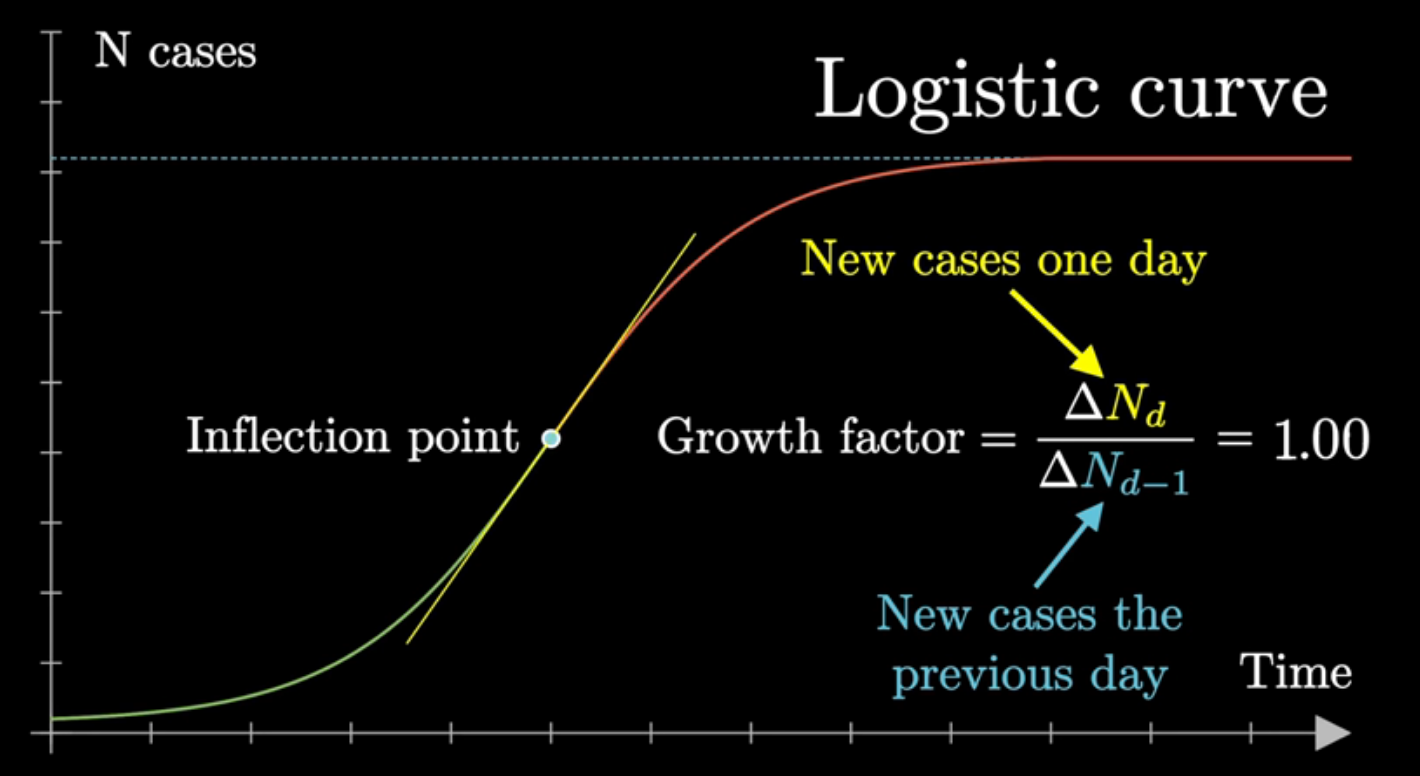

## Logistic Function

### A **logistic function** or **logistic curve** is an equation of the form: 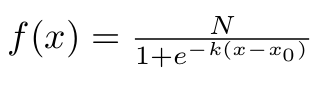
### where

### * x_0 = the inflection point,
### * N = the curve's maximum value, and
### * k = growth rate or steepness of the curve.

For reference: https://en.wikipedia.org/wiki/Logistic_function.
### Actually, the logistic function is just a solution for the following first-order, non-linear ordinary differential equation where f(0) = 0.5: 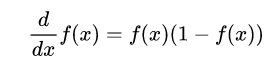

### From the differential equation, stability of solutions and equilibria can be explored. However, let's keep things simple for now and just look at the growth metrics.


# **The Analysis**

### Now that we have seen the math, let's explore the following growth metrics for the confirmed cases for each country:
### * Growth Factor
### * Growth Ratio
### * Growth Rate
### * 2nd Derivative

### We will use these growth metrics to gain insight into which countries may have already hit their inflection points. For example, if a country's growth factor has stabilized around 1.0 then this can be a sign that that country has reached it's inflection point. We will then use curve fitting to fit a logistic curve (similar to the one above) to the number of confirmed cases for each country. This may help us predict if a country has hit their inflection point, and therefore when they will reach a possible maximum number of confirmed cases.

### **Interestingly, the growth factor just tells us the curvature (from Calculus!) of the data.** If we take our data and take the 2nd derivative, basically all it is telling us is whether the cases are growing at an accelerating or decelerating rate. From calculus you may remember we use the 2nd derivative test to test for concavity and find saddle points. The inflection point is where the curve changes concavity. We can look at these growth metrics

### The bigger picture will be to correlate this with preventative efforts such as quarentines, closing of schools, etc. It will also be interesting to see growth factor as a feature in a ML prediction model. I plan on working on this shortly.

## Import Data

In [10]:
# Input data files are available in the "../input/" directory.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import os


# Any results you write to the current directory are saved as output.



In [17]:
global_data = pd.read_csv("C://Users//ENRISCOL//AAVsCovid//data//swiss_data.csv")
global_data.head()

Date  cases_AG  cases_AI  cases_AR  cases_BE  cases_BL  cases_BS  \
0  2020-02-25       NaN       NaN       NaN       NaN       NaN       NaN   
1  2020-02-26       NaN       NaN       NaN       NaN       NaN       NaN   
2  2020-02-27       NaN       NaN       NaN       NaN       NaN       0.0   
3  2020-02-28       1.0       NaN       NaN       NaN       1.0       0.0   
4  2020-02-29       NaN       NaN       NaN       NaN       2.0       0.0   

   cases_FR  cases_GE  cases_GL   ...     vent_SO  vent_SZ  vent_TG  vent_TI  \
0       NaN       NaN       NaN   ...         NaN      NaN      NaN      NaN   
1       NaN       1.0       NaN   ...         NaN      NaN      NaN      NaN   
2       NaN       1.0       NaN   ...         NaN      NaN      NaN      NaN   
3       NaN       3.0       NaN   ...         NaN      NaN      NaN      NaN   
4       NaN       5.0       NaN   ...         NaN      NaN      NaN      NaN   

   vent_UR  vent_VD  vent_VS  vent_ZG  vent_ZH  vent_CH  
0      NaN      NaN      NaN      NaN      NaN      0.0  
1      NaN      NaN      NaN      NaN      NaN      0.0  
2      NaN      NaN      NaN      NaN      NaN      0.0  
3      NaN      NaN      NaN      NaN      NaN      0.0  
4      NaN      NaN      NaN      NaN      NaN      0.0  

[5 rows x 163 columns]



* Define Active Cases as Confirmed minus Recovered minus Deaths.
* Drop SNo, Province/State, and Last Update.
* Plot Active, Confirmed, and Recovered Cases, Deaths, Growth Factor, 2nd_Derivative, and Growth Ratio

The **growth factor** on day N is the number of confirmed cases on day N minus confirmed cases on day N-1 divided by the number of confirmed cases on day N-1 minus confirmed cases on day N-2.

The **growth ratio** on day N is the number of confirmed cases on day N divided by the number of confirmed cases on day N-1.

Special thanks to Dan Pearson for the smoother function below, and for cleaning some of the code.

In [30]:
# This functions smooths data, thanks to Dan Pearson. We will use it to smooth the data for growth factor.
def smoother(inputdata,w,imax):
    data = 1.0*inputdata
    data = data.replace(np.nan,1)
    data = data.replace(np.inf,1)
    #print(data)
    smoothed = 1.0*data
    normalization = 1
    for i in range(-imax,imax+1):
        if i==0:
            continue
        smoothed += (w**abs(i))*data.shift(i,axis=0)
        normalization += w**abs(i)
    smoothed /= normalization
    return smoothed

def growth_factor(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    confirmed_iminus2 = confirmed.shift(2, axis=0)
    return (confirmed-confirmed_iminus1)/(confirmed_iminus1-confirmed_iminus2)

def growth_ratio(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    return (confirmed/confirmed_iminus1)

# This is a function which plots (for in input country) the active, confirmed, and recovered cases, deaths, and the growth factor.
def plot_country_active_confirmed_recovered(global_data, variable):
     
    table2=pd.DataFrame()
    table2['ConfirmedCases'] = global_data[variable]
   
    # Growth Factor
    w = 0.5
    table2['GrowthFactor'] = growth_factor(table2['ConfirmedCases'])
    table2['GrowthFactor'] = smoother(table2['GrowthFactor'],w,5)

    # 2nd Derivative
    table2['2nd_Derivative'] = np.gradient(np.gradient(table2['ConfirmedCases'])) #2nd derivative
    table2['2nd_Derivative'] = smoother(table2['2nd_Derivative'],w,7)


    #Plot confirmed[i]/confirmed[i-1], this is called the growth ratio
    table2['GrowthRatio'] = growth_ratio(table2['ConfirmedCases'])
    table2['GrowthRatio'] = smoother(table2['GrowthRatio'],w,5)
    
    #Plot the growth rate, we will define this as k in the logistic function presented at the beginning of this notebook.
    table2['GrowthRate']=np.gradient(np.log(table2['ConfirmedCases']))
    table2['GrowthRate'] = smoother(table2['GrowthRate'],0.5,3)
    
    # horizontal line at growth rate 1.0 for reference
    x_coordinates = [1, 100]
    y_coordinates = [1, 1]
    #plots
    table2["ConfirmedCases"].plot(title='ICU_number')
    plt.show()
    table2['GrowthFactor'].plot(title='Growth Factor')
    plt.plot(x_coordinates, y_coordinates) 
    plt.show()
    table2['2nd_Derivative'].plot(title='2nd_Derivative')
    plt.show()
    table2['GrowthRatio'].plot(title='Growth Ratio')
    plt.plot(x_coordinates, y_coordinates)
    plt.show()
    table2['GrowthRate'].plot(title='Growth Rate')
    plt.show()


    return 


## CH

C:\Users\ENRISCOL\AppData\Local\Continuum\anaconda3\envs\axpo\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


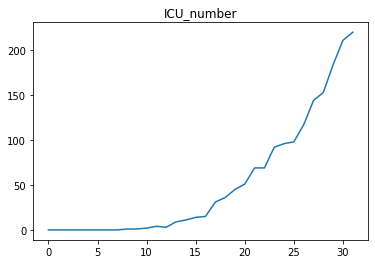

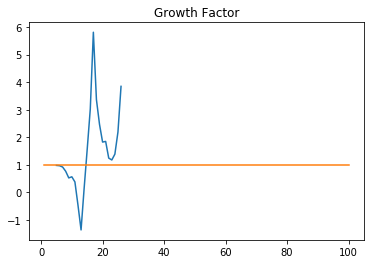

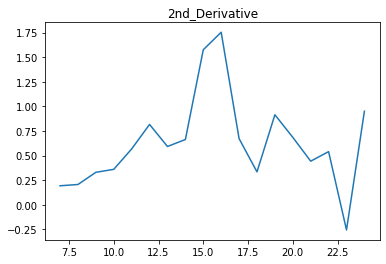

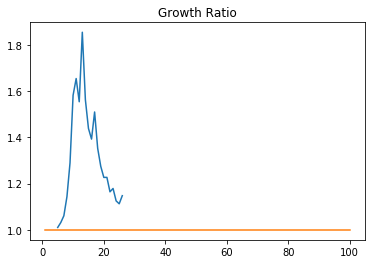

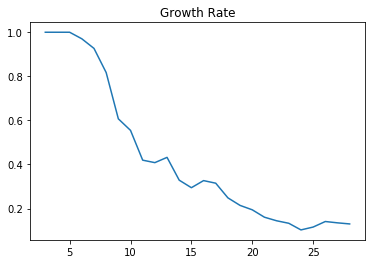

In [31]:
plot_country_active_confirmed_recovered(global_data, "icu_CH")

# **Logistic Curve Fitting**

Now that things are smooth, we can fit :-)

We are going to use scipy.optimize.curve_fit to fit a logistic curve to the number of confirmed cases in China and South Korea.

In [37]:
from scipy.optimize import curve_fit


In [40]:
country_data = global_data['icu_CH']

country_data.tail()

27    144.0
28    153.0
29    184.0
30    211.0
31    220.0
Name: icu_CH, dtype: float64

In [47]:
#country_data['GrowthFactor'] = growth_factor(country_data['Confirmed'])

# we will want x_data to be the number of days since first confirmed and the y_data to be the confirmed data. This will be the data we use to fit a logistic curve
x_data = range(len(country_data.index))
y_data = country_data

def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

# Fit the curve
popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0,0,0],np.inf), maxfev=5000)
estimated_k, estimated_x_0, ymax= popt

x_data = np.arange(40)
# Plot the fitted curve
k = estimated_k
x_0 = estimated_x_0
y_fitted = log_curve(x_data, k, x_0, ymax)
print(k, x_0, ymax)
#print(y_fitted)
y_data.tail()

0.20589287718442467 29.49477490057203 383.8930487881958


27    144.0
28    153.0
29    184.0
30    211.0
31    220.0
Name: icu_CH, dtype: float64

In [50]:
y_fitted

array([  0.88275974,   1.08400779,   1.33097614,   1.63397085,
         2.00558025,   2.4611596 ,   3.01940824,   3.70305145,
         4.53963769,   5.56245868,   6.81159246,   8.33505803,
        10.19005067,  12.44419823,  15.17673649,  18.47944379,
        22.4570998 ,  27.22714227,  32.91809743,  39.66627273,
        47.61016126,  56.88206622,  67.59668069,  79.83681715,
        93.63720121, 108.96816489, 125.72199708, 143.70528626,
       162.64041143, 182.1781142 , 201.92088655, 221.45428867,
       240.38116485, 258.35290162, 275.09271298, 290.40809349,
       304.1922006 , 316.41611725, 327.11515781, 336.37254958])

Text(0, 0.5, 'Numbers of ICUs')

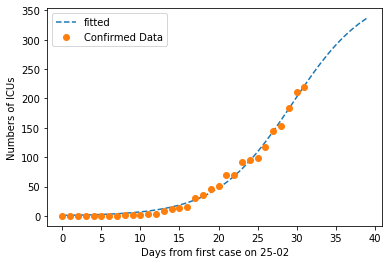

In [61]:
# Plot everything for illustration
fig = plt.figure()
plt.plot(x_data, y_fitted, '--', label='fitted')
plt.plot(np.arange(32), y_data, 'o', label='Confirmed Data')
plt.legend()
plt.xlabel("Days from first case on 25-02")
plt.ylabel("Numbers of ICUs")
